In [3]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.stats import norm
from tqdm import tqdm

def calculate_om0_distributions(x, omm_min_sne, omm_min_bao, omm_std_sne, omm_std_bao, weights=None, n_jobs=-1):
    total_subtraction = np.zeros_like(x)

    combined_data = np.column_stack((omm_min_sne, omm_min_bao, omm_std_sne, omm_std_bao))

    out_of_range_mask = (combined_data[:, 0] < 0.003) | (combined_data[:, 0] > 0.997) | \
                        (combined_data[:, 1] < 0.003) | (combined_data[:, 1] > 0.997)

    combined_data[out_of_range_mask, :2] = np.nan
    omm_min_sne, omm_min_bao, omm_std_sne, omm_std_bao = combined_data.T

    def process_single(mu_sne, mu_bao, sigma_sne, sigma_bao, weight):
        if not np.isnan(mu_sne) and not np.isnan(mu_bao) and not np.isnan(sigma_sne) and not np.isnan(sigma_bao):
            return weight * norm.pdf(x, mu_sne - mu_bao, (sigma_sne ** 2 + sigma_bao ** 2) ** 0.5)
        return np.zeros_like(x)

    if weights is not None:
        weights = np.array(weights)
        if weights.size != len(omm_min_sne):
            raise ValueError("Weights need same with #parameters")
        else:
            weights = weights / np.sum(weights)
            results = Parallel(n_jobs=n_jobs)(
                delayed(process_single)(mu_sne, mu_bao, sigma_sne, sigma_bao, weight)
                for mu_sne, mu_bao, sigma_sne, sigma_bao, weight in
                tqdm(zip(omm_min_sne, omm_min_bao, omm_std_sne, omm_std_bao, weights), total=len(weights))
            )
    else:
        results = Parallel(n_jobs=n_jobs)(
            delayed(process_single)(mu_sne, mu_bao, sigma_sne, sigma_bao, 1.0)
            for mu_sne, mu_bao, sigma_sne, sigma_bao in
            tqdm(zip(omm_min_sne, omm_min_bao, omm_std_sne, omm_std_bao), total=len(omm_min_sne))
        )

    for result in results:
        total_subtraction += result

    return total_subtraction

desy5_data = np.load('desy5_results.npz')
h0_min_sne_desy5 = desy5_data['h0_min_sne_desy5']
omm_min_sne_desy5 = desy5_data['omm_min_sne_desy5']
h0_std_sne_desy5 = desy5_data['h0_std_sne_desy5']
omm_std_sne_desy5 = desy5_data['omm_std_sne_desy5']
h0_min_bao_desy5 = desy5_data['h0_min_bao_desy5']
omm_min_bao_desy5 = desy5_data['omm_min_bao_desy5']
h0_std_bao_desy5 = desy5_data['h0_std_bao_desy5']
omm_std_bao_desy5 = desy5_data['omm_std_bao_desy5']
param_desy5 = desy5_data['param_desy5']

all_data = np.load('all_data_results.npz')
h0_min_sne_all = all_data['h0_min_sne_all']
omm_min_sne_all = all_data['omm_min_sne_all']
h0_std_sne_all = all_data['h0_std_sne_all']
omm_std_sne_all = all_data['omm_std_sne_all']
h0_min_bao_all = all_data['h0_min_bao_all']
omm_min_bao_all = all_data['omm_min_bao_all']
h0_std_bao_all = all_data['h0_std_bao_all']
omm_std_bao_all = all_data['omm_std_bao_all']
param_all = all_data['param_all']

100%|██████████| 10000/10000 [00:00<00:00, 42409.33it/s]


All Data - Peak: 0.0526, Mean: 0.0354, Std Dev: 0.0837
DESY5 Data - Peak: -0.2968, Mean: -0.2586, Std Dev: 0.1011
All Data - 68% Confidence Interval: [-0.0046, 0.0837]
DESY5 Data - 68% Confidence Interval: [-0.3517, -0.1652]


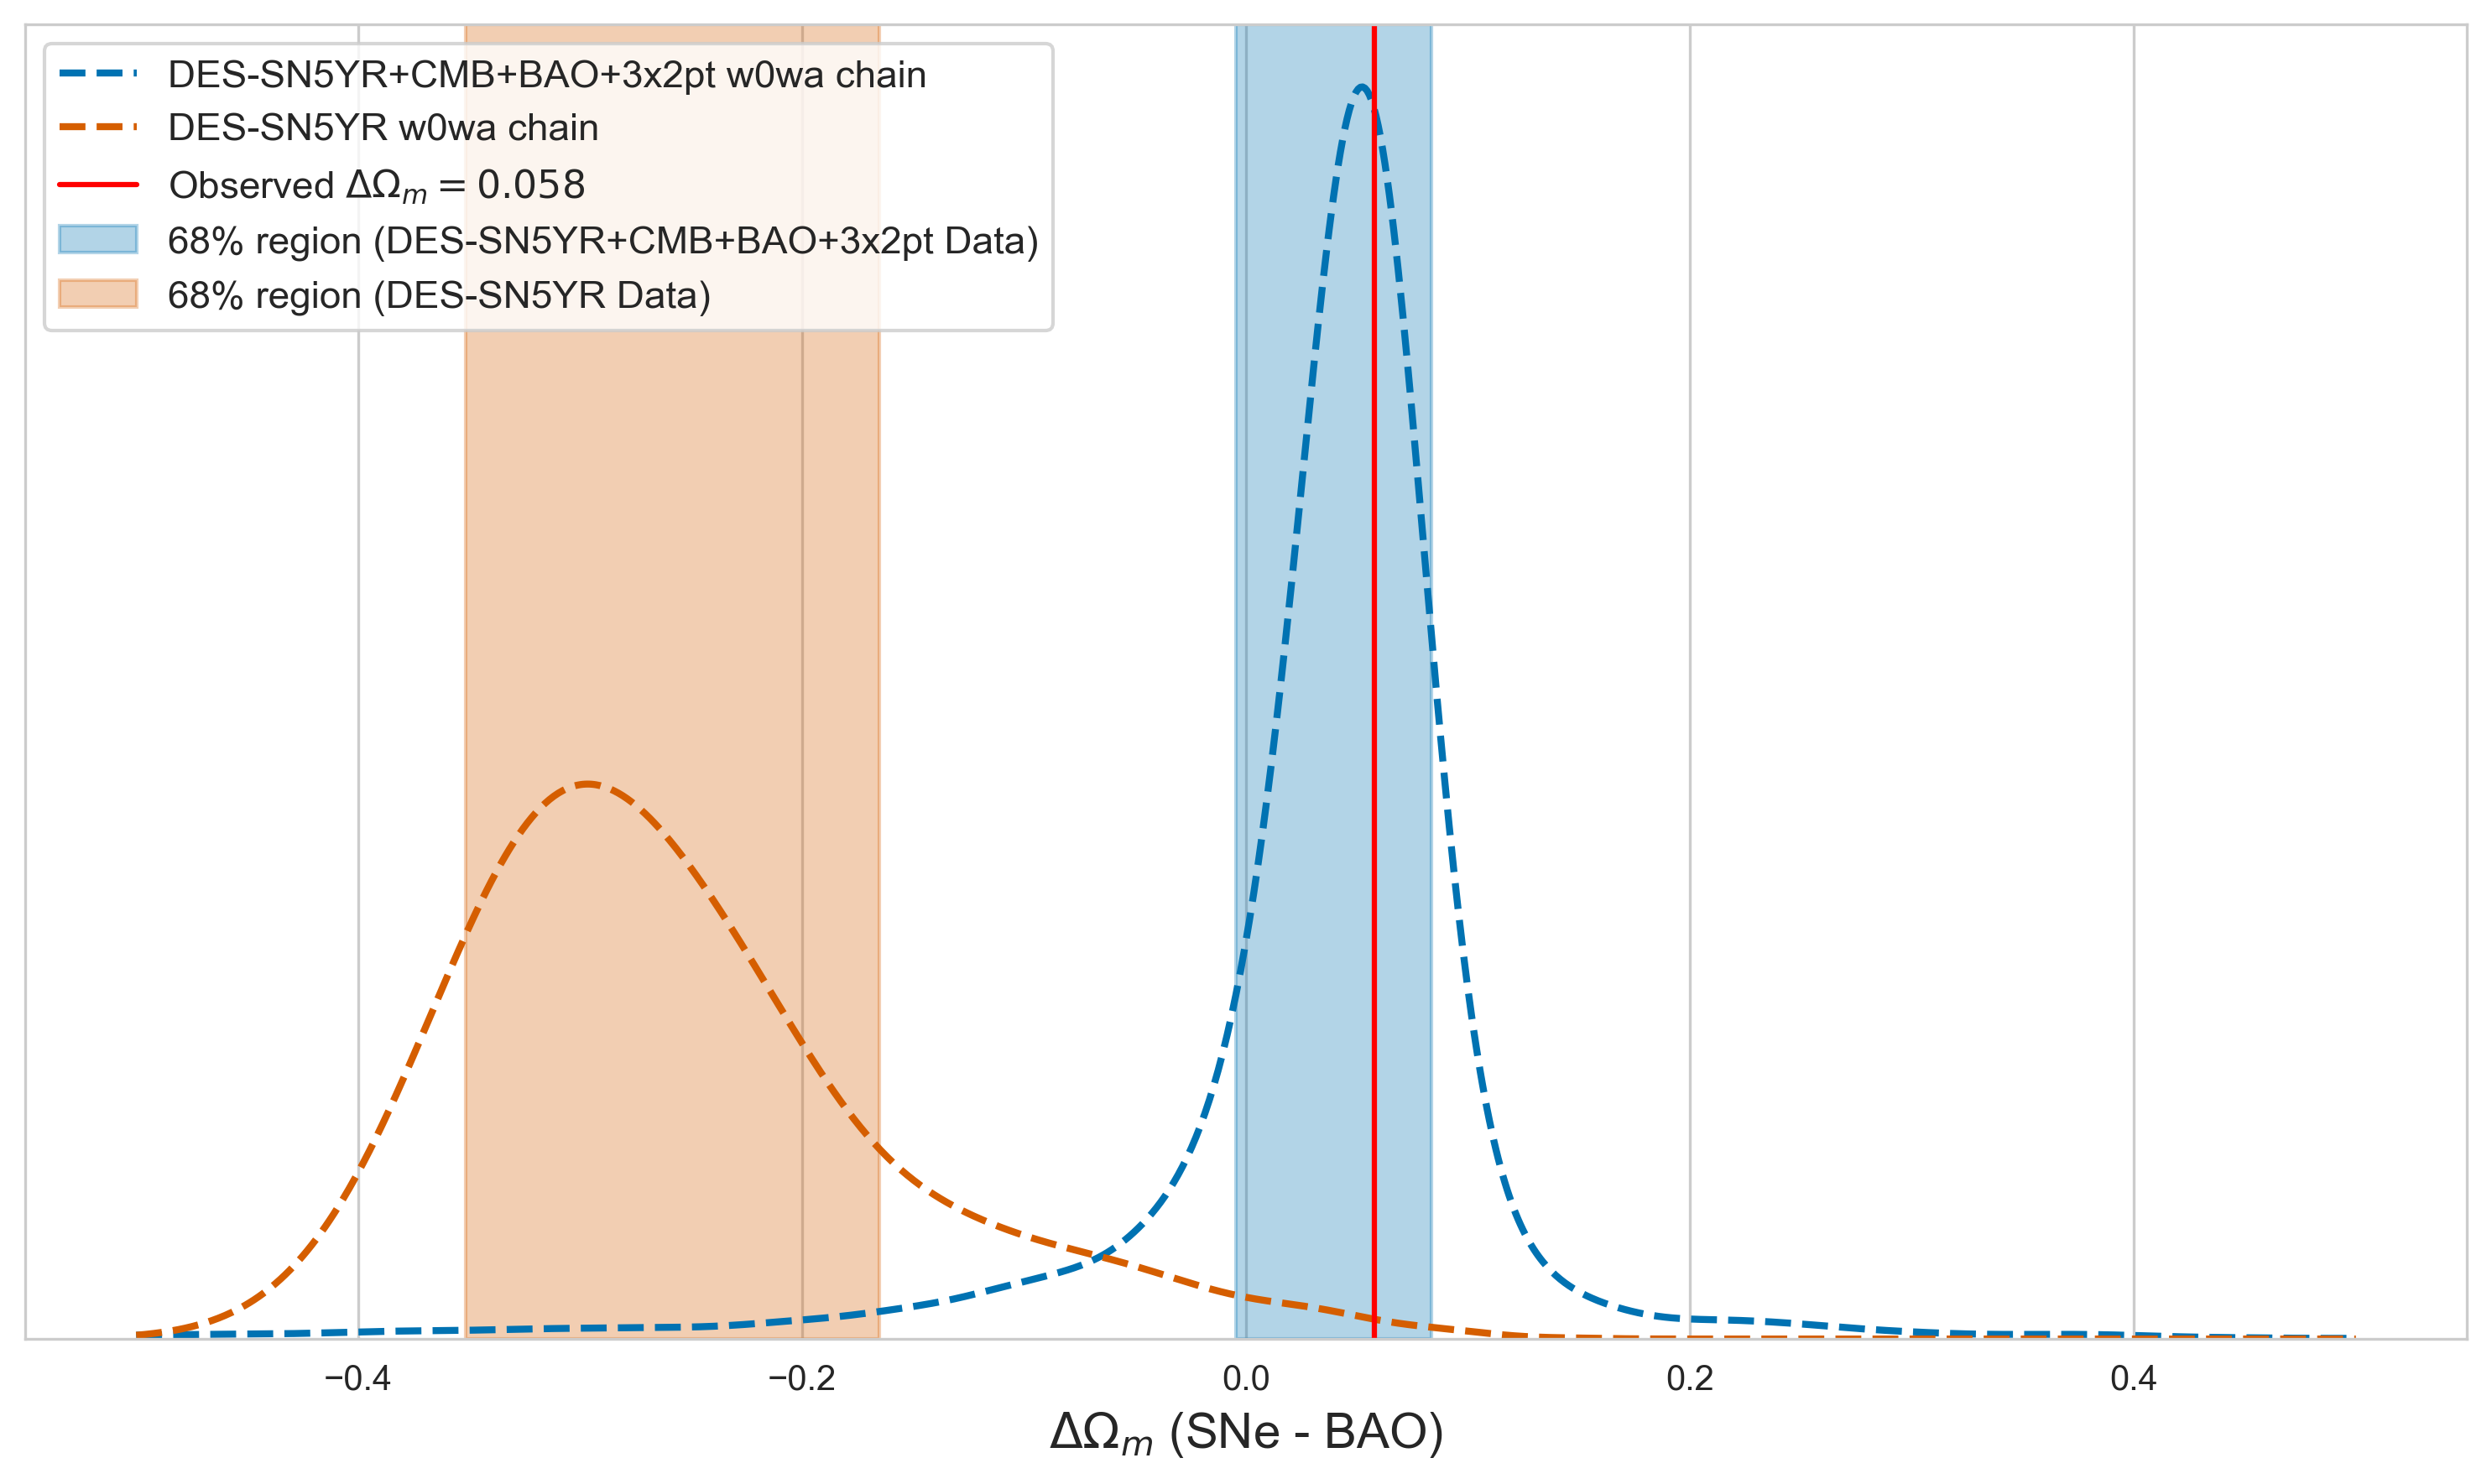

In [4]:
from scipy.integrate import cumulative_trapezoid

def find_confidence_interval(x, y, confidence_level=0.68):
    y = y / np.trapz(y, x)

    cumulative_prob = cumulative_trapezoid(y, x, initial=0)

    #total_prob = cumulative_prob[-1]

    lower_bound = np.interp((1 - confidence_level) / 2, cumulative_prob, x)
    upper_bound = np.interp(1 - (1 - confidence_level) / 2, cumulative_prob, x)

    return lower_bound, upper_bound


def plot_delta_omm_multiple(dataname, omm_min_sne_all, omm_min_bao_all, omm_std_sne_all, omm_std_bao_all, 
                            omm_min_sne_desy5, omm_min_bao_desy5, omm_std_sne_desy5, omm_std_bao_desy5,
                            x_vals=np.linspace(-0.5, 0.5, 1000)):
    
    y_vals_all = calculate_om0_distributions(x_vals, omm_min_sne_all, omm_min_bao_all, omm_std_sne_all, omm_std_bao_all)
    y_vals_all = y_vals_all / np.trapz(y_vals_all, x_vals)  
    
    y_vals_desy5 = calculate_om0_distributions(x_vals, omm_min_sne_desy5, omm_min_bao_desy5, omm_std_sne_desy5, omm_std_bao_desy5)
    y_vals_desy5 = y_vals_desy5 / np.trapz(y_vals_desy5, x_vals)  # normalize

    plot_multiple_domm_plot(x_vals, y_vals_all, y_vals_desy5, dataname)

def plot_multiple_domm_plot(x_vals, y_vals_all, y_vals_desy5, dataname_file_string):
    plt.figure(figsize=(10, 6), dpi=300)

    color_all = '#0072B2'  
    color_desy5 = '#D55E00'  
    
    plt.plot(x_vals, y_vals_all, color=color_all, linestyle='--', label=r'DES-SN5YR+CMB+BAO+3x2pt w0wa chain', linewidth=2)
    plt.plot(x_vals, y_vals_desy5, color=color_desy5, linestyle='--', label=r'DES-SN5YR w0wa chain', linewidth=2)

    plt.axvline(0.058, color='red', linestyle='-', label=f'Observed $\\Delta \\Omega_m = 0.058$', linewidth=1.5)

    ylim = plt.ylim()

    peak_index_all = np.argmax(y_vals_all)
    peak_x_all = x_vals[peak_index_all]
    mean_all = np.trapz(x_vals * y_vals_all, x_vals)
    variance_all = np.trapz((x_vals - mean_all) ** 2 * y_vals_all, x_vals)
    std_dev_all = np.sqrt(variance_all)
    
    peak_index_desy5 = np.argmax(y_vals_desy5)
    peak_x_desy5 = x_vals[peak_index_desy5]
    mean_desy5 = np.trapz(x_vals * y_vals_desy5, x_vals)
    variance_desy5 = np.trapz((x_vals - mean_desy5) ** 2 * y_vals_desy5, x_vals)
    std_dev_desy5 = np.sqrt(variance_desy5)
    
    print(f'All Data - Peak: {peak_x_all:.4f}, Mean: {mean_all:.4f}, Std Dev: {std_dev_all:.4f}')
    print(f'DESY5 Data - Peak: {peak_x_desy5:.4f}, Mean: {mean_desy5:.4f}, Std Dev: {std_dev_desy5:.4f}')
    
    lower_all, upper_all = find_confidence_interval(x_vals, y_vals_all)
    lower_desy5, upper_desy5 = find_confidence_interval(x_vals, y_vals_desy5)

    print(f'All Data - 68% Confidence Interval: [{lower_all:.4f}, {upper_all:.4f}]')
    print(f'DESY5 Data - 68% Confidence Interval: [{lower_desy5:.4f}, {upper_desy5:.4f}]')

    ylim = plt.ylim()  
    
    plt.fill_betweenx([0, ylim[1]], lower_all, upper_all, color=color_all, alpha=0.3, 
                  label='68% region (DES-SN5YR+CMB+BAO+3x2pt Data)')
    plt.fill_betweenx([0, ylim[1]], lower_desy5, upper_desy5, color=color_desy5, alpha=0.3, 
                  label='68% region (DES-SN5YR Data)')


    plt.xlabel(r'$\Delta \Omega_m$ (SNe - BAO)', fontsize=14)
    plt.ylim(0, ylim[1])
    plt.gca().get_yaxis().set_visible(False)
    
    plt.legend(fontsize=11, loc='upper left')
    plt.tight_layout()

    plt.savefig('delta_omega_m_plot_all_vs_desy5_1sigma.png', format='png', dpi=900)
    plt.show()

plot_delta_omm_multiple('DES-SN5YR+CMB+BAO+3x2pt', omm_min_sne_all, omm_min_bao_all, omm_std_sne_all, omm_std_bao_all, 
                        omm_min_sne_desy5, omm_min_bao_desy5, omm_std_sne_desy5, omm_std_bao_desy5)